In [1]:
import numpy as np
import cv2
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
from tqdm import tqdm
import matplotlib.pyplot as plt
import rawpy
from utils import parse_anno_file, create_mask_file

%matplotlib inline

In [2]:
path_to_data = 'data/stones'
anno = parse_anno_file(os.path.join(path_to_data, 'annotation.xml'))

In [3]:
mask_asbest = create_mask_file(anno[0], 'asbest')
mask_stone = create_mask_file(anno[0], 'stone')

raw = rawpy.imread(os.path.join(path_to_data, anno[0]['name'].split('/')[-1]))
image = raw.postprocess()

y, x = np.where(mask_stone != 0)
image[np.where(mask_stone == 0)] = 0
image = image[min(y):max(y), min(x):max(x)]
mask_stone = mask_stone[min(y):max(y), min(x):max(x)]
mask_asbest = mask_asbest[min(y):max(y), min(x):max(x)]

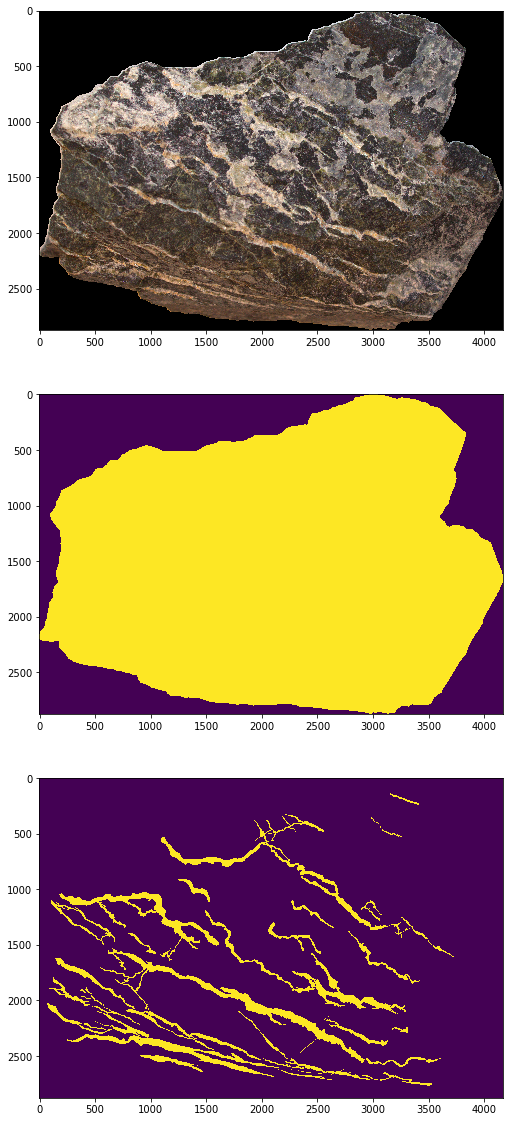

In [4]:
plt.figure(figsize=(10,20))
plt.subplot(311)
plt.imshow(image)
plt.subplot(312)
plt.imshow(mask_stone)
plt.subplot(313)
plt.imshow(mask_asbest)

In [7]:
# val_mask_asbest = create_mask_file(anno[0], 'asbest')
val_mask_stone = create_mask_file(anno[1], 'stone')

raw = rawpy.imread(os.path.join(path_to_data, anno[-1]['name'].split('/')[-1]))
val_image = raw.postprocess()

y, x = np.where(val_mask_stone != 0)
val_image[np.where(val_mask_stone == 0)] = 0
val_image = val_image[min(y):max(y), min(x):max(x)]
val_mask_stone = val_mask_stone[min(y):max(y), min(x):max(x)]
# mask_asbest = mask_asbest[min(y):max(y), min(x):max(x)]

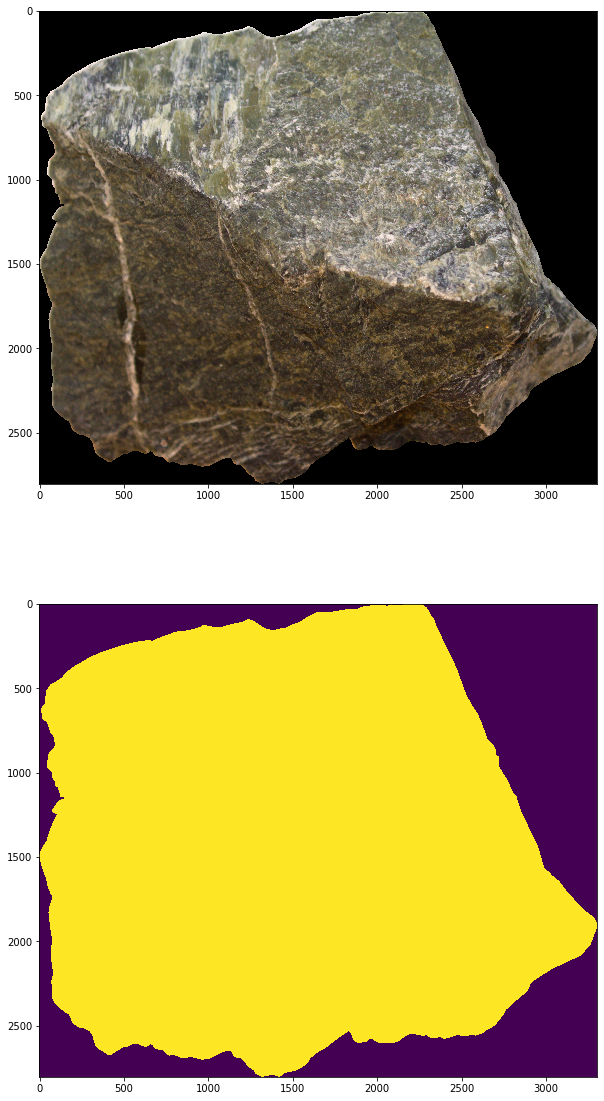

In [8]:
plt.figure(figsize=(10,20))
plt.subplot(211)
plt.imshow(val_image)
plt.subplot(212)
plt.imshow(val_mask_stone)

In [19]:
from torch.utils.data import Dataset
class Asbest(Dataset):
    def __init__(self, image, mask_st, mask_asb, img_size=(448,448)):
#         super().__init__()
        h, w = image.shape[:2]
        num_img_y = int(np.ceil(h / img_size[0])) - 1
        num_img_x = int(np.ceil(w / img_size[1])) - 1
        
        self.images = []
        self.masks = []
        for j in range(num_img_y):
            for i in range(num_img_x):
                msk_st = mask_st[j*img_size[0]:(j+1)*img_size[0], i*img_size[1]:(i+1)*img_size[1]]

                if np.sum(msk_st != 0) < 5e+4:
                    continue
                    
                self.images.append(image[j*img_size[0]:(j+1)*img_size[0], i*img_size[1]:(i+1)*img_size[1]])
                self.masks.append(mask_asb[j*img_size[0]:(j+1)*img_size[0], i*img_size[1]:(i+1)*img_size[1]])
        
                    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img = self.images[index].transpose(2,0,1) / 255
        msk = np.expand_dims(self.masks[index],axis=0) / 255
             
        return img, msk

In [20]:
train_dataset = Asbest(image, mask_stone, mask_asbest)

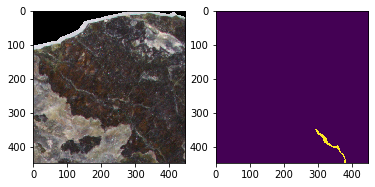

In [21]:
img, msk = train_dataset[1]
plt.subplot(121)
plt.imshow(img.transpose(1,2,0))
plt.subplot(122)
plt.imshow(np.squeeze(msk))

In [22]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
# valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=2)

In [23]:
next(iter(train_loader))[1].shape

torch.Size([8, 1, 448, 448])

In [24]:
import segmentation_models_pytorch as smp

In [25]:
class AverageMeter(object):
    def __init__(self):
        self.initialized = False
        self.val = None
        self.avg = None
        self.sum = None
        self.count = None

    def initialize(self, val, weight):
        self.val = val
        self.avg = val
        self.sum = val * weight
        self.count = weight
        self.initialized = True

    def update(self, val, weight=1):
        if not self.initialized:
            self.initialize(val, weight)
        else:
            self.add(val, weight)

    def add(self, val, weight):
        self.val = val
        self.sum += val * weight
        self.count += weight
        self.avg = self.sum / self.count

    def value(self):
        return self.val

    def average(self):
        return self.avg

In [26]:
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = smp.Unet(encoder_name='resnet50').to(device)

criterion = smp.utils.losses.BCEDiceLoss()
# criterion = nn.CrossEntropyLoss()
# criterion.__name__= 'loss'


def pixel_acc(pred, label):
        _, preds = torch.max(pred, dim=1)
        valid = (label >= 0).long()
        acc_sum = torch.sum(valid * (preds == label).long())
        pixel_sum = torch.sum(valid)
        acc = acc_sum.float() / (pixel_sum.float() + 1e-10)
        return acc


metrics = [
    smp.utils.metrics.IoUMetric(eps=1.),
    smp.utils.metrics.FscoreMetric(eps=1.),
]


optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-4}, 

    {'params': model.encoder.parameters(), 'lr': 1e-4},  
])

In [27]:
def predict(model, image, inp_size=(448,448)):
    
    h, w = image.shape[:2]
    mask = np.zeros(image.shape[:2])
    num_img_y = int(np.ceil(h / inp_size[0]))
    num_img_x = int(np.ceil(w / inp_size[1]))

    
    for j in range(num_img_y):
        for i in range(num_img_x):
            part_image = image[j*inp_size[0]:(j+1)*inp_size[0], i*inp_size[1]:(i+1)*inp_size[1]]
            init_shape = part_image.copy().shape[:2]
            
            if part_image.shape[0] < inp_size[0]:
                part_image = np.concatenate((part_image, np.zeros((inp_size[0] - part_image.shape[0], part_image.shape[1], part_image.shape[2]))), axis=0)
            
            if part_image.shape[1] < inp_size[1]:
                part_image = np.concatenate((part_image, np.zeros((part_image.shape[0], inp_size[1] - part_image.shape[1], part_image.shape[2]))), axis=1)
            
            part_image = torch.tensor(np.expand_dims((part_image / 255).transpose((2,0,1)), axis=0)).to(device).float()
            
            out_mask = model.activation(model(part_image))
            out_mask = np.squeeze(out_mask.cpu().detach().numpy())[:init_shape[0], :init_shape[1]]
#             print(out_mask.shape)
            mask[j*inp_size[0]:(j+1)*inp_size[0], i*inp_size[1]:(i+1)*inp_size[1]] = out_mask
#             out_mask.
#             self.images.append()
#             self.masks.append(mask_asb[j*img_size[0]:(j+1)*img_size[0], i*img_size[1]:(i+1)*img_size[1]])
    return mask

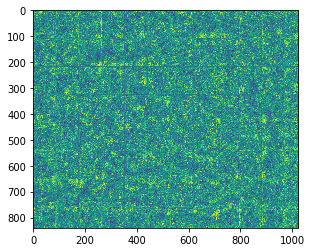

In [28]:
raw = rawpy.imread(os.path.join(path_to_data, anno[0]['name'].split('/')[-1]))
val_image = raw.postprocess()
mask = predict(model, val_image)
mask = cv2.resize(mask, (1024, 840))
plt.imshow(mask)

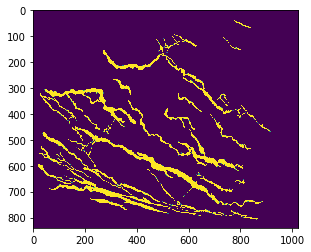

In [29]:
mask = cv2.resize(mask_asbest, (1024, 840))
plt.imshow(mask)

In [ ]:
from tqdm import trange, tqdm

epochs = 50

for epoch in range(epochs):
    
    average_total_loss = AverageMeter()
    average_acc = AverageMeter()
    average_iou = AverageMeter()
    average_fscore = AverageMeter()
    average_total_val_loss = AverageMeter()
    average_val_acc = AverageMeter()
    
    model.train(True)
    with tqdm(total=len(train_loader), 
              bar_format='{desc} epoch {postfix[0]} ' + 
              '| {n_fmt}/{total_fmt} {elapsed}<{remaining} ' + 
              '| loss : {postfix[1]:>2.4f} ' + 
              '| acc : {postfix[2]:>2.4f} ' + 
              '| iou: {postfix[3]:>2.4f} ' + 
              '| fscore: {postfix[4]:>2.4f}', 
              postfix=[0, 0, 0, 0, 0], desc = 'Training') as t:
        t.postfix[0] = epoch + 1
        for data in train_loader:

            torch.cuda.empty_cache()
            inputs, masks = data

            inputs=inputs.to(device).float()
            masks=masks.to(device).float()

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, masks)
            acc = pixel_acc(outputs, masks)
            iou = metrics[0](outputs, masks)
            fscore = metrics[1](outputs, masks)

            loss.backward()
            optimizer.step()

            average_total_loss.update(loss.data.item())
            average_acc.update(acc.data.item())
            average_iou.update(iou.data.item())
            average_fscore.update(fscore.data.item())
            
            t.postfix[1] = average_total_loss.average()
            t.postfix[2] = average_acc.average()
            t.postfix[3] = average_iou.average()
            t.postfix[4] = average_fscore.average()
            t.update()

    ## Validation
    model.train(False)
    mask = predict(model, image)
    mask = cv2.resize(mask, (1024, 840))
    cv2.imwrite(os.path.join('result', 'train.bmp'), 255*(mask > 0.5))
    
    mask = predict(model, val_image)
    mask = cv2.resize(mask, (1024, 840))
    cv2.imwrite(os.path.join('result', 'valid.bmp'), 255*(mask > 0.5))

Training epoch 1 | 6/6 00:03<00:00 | loss : 1.6095 | acc : 7.0625 | iou: 0.1417 | fscore: 0.2452
Training epoch 2 | 6/6 00:03<00:00 | loss : 1.4346 | acc : 7.0625 | iou: 0.2175 | fscore: 0.3560
Training epoch 3 | 6/6 00:03<00:00 | loss : 1.3550 | acc : 7.0625 | iou: 0.2705 | fscore: 0.4219
Training epoch 4 | 6/6 00:03<00:00 | loss : 1.3010 | acc : 7.0625 | iou: 0.3081 | fscore: 0.4639
Training epoch 5 | 6/6 00:03<00:00 | loss : 1.2550 | acc : 7.0625 | iou: 0.3476 | fscore: 0.5065
Training epoch 6 | 6/6 00:03<00:00 | loss : 1.2118 | acc : 7.0625 | iou: 0.3644 | fscore: 0.5287
Training epoch 7 | 6/6 00:03<00:00 | loss : 1.1603 | acc : 7.0625 | iou: 0.4129 | fscore: 0.5838
Training epoch 8 | 6/6 00:03<00:00 | loss : 1.1300 | acc : 7.0625 | iou: 0.4421 | fscore: 0.6093
Training epoch 9 | 6/6 00:03<00:00 | loss : 1.0869 | acc : 7.0625 | iou: 0.4998 | fscore: 0.6631
Training epoch 10 | 6/6 00:03<00:00 | loss : 1.0598 | acc : 7.0625 | iou: 0.5655 | fscore: 0.7204
Training epoch 11 | 6/6 00:03

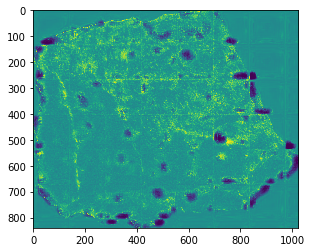

In [92]:
plt.imshow(mask)